## Create Our Dataloader

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

import torch
from torch.utils.data import Dataset, DataLoader

# ============== Location for our dataset ================
try:
    current_file_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Fallback for environments where __file__ is not defined (e.g., Jupyter notebooks)
    current_file_dir = os.getcwd()

root = os.path.abspath(os.path.join(current_file_dir, '..', '..'))
PARQUET_FILE = os.path.join(root, 'evaluation', 'ibot_traindata', 'ibot_traindata_aggregate.parquet')


# ============== Naive dataset / dataloader implementation ================
class ParquetDataset(Dataset):
    def __init__(self, parquet_file):
        df = pd.read_parquet(parquet_file)
        self.samples = df['data'].tolist()
        self.tensors = [self.convert_to_tensor(sample) for sample in self.samples]

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        return self.tensors[idx]

    @staticmethod
    def convert_to_tensor(sample):
        if isinstance(sample, list):
            sample = [np.array(sublist, dtype=np.float32) if isinstance(sublist, np.ndarray) else sublist for sublist in sample]
            return torch.tensor(sample, dtype=torch.float32)
        elif isinstance(sample, np.ndarray):
            return torch.tensor(sample.tolist(), dtype=torch.float32)
        else:
            raise TypeError(f"Unsupported sample type: {type(sample)}")


def get_dataloader(batch_size=1, shuffle=True):
    """
        Returns a dataloader object (loads in data from the global var in this file (PARQUET_FILE).

        All elements in the dataloader object are of type 'tensor' (specifically, 3-D tensor but each has only 2-Ds).
    """
    dataset = ParquetDataset(PARQUET_FILE)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    print(f"Dataloader of length {len(dataloader)} successfully created from {PARQUET_FILE}")
    return dataloader



# Usage
dataloader = get_dataloader()
test_data = None
for data in dataloader:
    test_data = data[0]
    print(test_data)
    break

Dataloader of length 6581 successfully created from C:\Users\lucas\Desktop\Lucas\Coding\ML Research\ARC Prize\evaluation\ibot_traindata\ibot_traindata_aggregate.parquet
tensor([[0., 0., 0.],
        [5., 0., 0.],
        [0., 0., 0.]])


C:\Users\lucas\AppData\Local\Temp\ipykernel_23392\1708929901.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.tensor(sample.tolist(), dtype=torch.float32)


In [2]:
class DataAugmentationiBOT(object):
    """
        Updated from original iBOT implementation.
    """
    def __init__(self, global_crops_number, local_crops_number, pad_to_32=True):
        self.global_crops_number = global_crops_number
        self.local_crops_number = local_crops_number
        self.pad_to_32 = pad_to_32

    def pad_image(self, image):
        """ 
            Returns padded image, height, and width.
        
            Padded image is either 32x32 or the largest multiple of 4 greater than the height and width of the input image,
            with padding set to -1, and image is placed in the top left corner.
        """
        if isinstance(image, np.ndarray):
            height, width = image.shape
        elif isinstance(image, torch.Tensor):
            height, width = image.size()
            image = image.numpy()
        else:
            raise TypeError("Input must be a 2-D NumPy array or a PyTorch tensor.")

        if self.pad_to_32:
            padded_height = 32
            padded_width = 32
        else:
            padded_height = (height + 3) // 4 * 4
            padded_width = (width + 3) // 4 * 4

        padded_image = np.full((padded_height, padded_width), -1, dtype=int)
        padded_image[:height, :width] = image
        return padded_image, height, width

    def globalcrop1(self, image):
        padded_image, height, width = self.pad_image(image)
        padded_height, padded_width = padded_image.shape
        max_shift_y = padded_height - height
        max_shift_x = padded_width - width
        shift_y = random.randint(0, max_shift_y)
        shift_x = random.randint(0, max_shift_x)
        transformed_image = np.full((padded_height, padded_width), -1, dtype=int)
        transformed_image[shift_y:shift_y + height, shift_x:shift_x + width] = padded_image[:height, :width]
        return transformed_image

    def globalcrop2(self, image):
        padded_image, height, width = self.pad_image(image)
        digits = list(range(10))
        random.shuffle(digits)
        mapping = {i: digits[i] for i in range(10)}
        transformed_image = np.array([[mapping[pixel] if pixel != -1 else -1 for pixel in row] for row in padded_image])
        return transformed_image

    def localcrop(self, image):
        """ Placeholder for localcrop, may implement in future. """
        return image

    def __call__(self, image):
        """ Image must be a 2-D NumPy array or a PyTorch tensor """
        if not (isinstance(image, np.ndarray) or isinstance(image, torch.Tensor)):
            raise TypeError("Input must be a 2-D NumPy array or a PyTorch tensor.")
    
        crops = []
        for _ in range(self.global_crops_number):
            crop = self.globalcrop1(image)
            crops.append(torch.tensor(self.globalcrop2(crop), dtype=torch.float32))
        for _ in range(self.local_crops_number):
            pass  # crops.append(self.localcrop(image))
        return crops

In [3]:
class iBOT_Dataloader():
    """ Dataloader wrapper that applies data augmentations / transformations while also loading in our data. """
    def __init__(self, dataloader, args_dict):
        self.dataloader = dataloader
        self.data_iterator = iter(dataloader)
        self.args = args_dict
        self.augmenter = DataAugmentationiBOT(2, 0)

    def get_data(self):
        """ Function that returns the next data point, augmented (see DataAugmentationiBOT), and converted to channels. """
        generating = True
        datum = None
        
        while generating:
            try:
                datum = next(self.data_iterator)[0]
                generating = False
            except StopIteration:
                self.data_iterator = iter(self.dataloader)

        aug_data = self.augmenter(datum)
        aug_data = [self._create_channels(d) for d in aug_data]
        return aug_data

    def _generate_mask(self, image):
        """ Placeholder for mask generation function. """
        return (image % 2 == 0).int()  # Example: mask even values

    def _create_channels(self, image):
        """
            Accepts list of tensors and returns original image and the masked image.
            Returns image with 6 channels:
                1) Mask Channel: 1 if pixel is masked, 0 otherwise
                2) Padding Channel: 1 if pixel is from image, 0 if pixel is padding
                3) Value Channels (4x): Binary encoding of pixel value (1-10)
        """
        H, W = image.shape if isinstance(image, np.ndarray) else image.size()
        image = image + 1  # Adjust values from 0-9 to 1-10
    
        mask = self._generate_mask(image)
        
        padded_image = np.full((H, W), -1, dtype=int)
        padded_image[:H, :W] = image
        padded_image[mask == 1] = -2  # Apply mask
        
        mask_channel = mask.numpy() if isinstance(mask, torch.Tensor) else mask
        padding_channel = np.ones((H, W), dtype=int)
    
        num_value_channels = 4
        value_channels = np.unpackbits(np.uint8(padded_image.clip(0, 15))[:, :, np.newaxis], axis=2)[:, :, -num_value_channels:]
        
        original_image_tensor = np.stack([mask_channel, padding_channel] + [value_channels[:, :, i] for i in range(num_value_channels)], axis=0)
        
        padded_image[mask == 1] = 0
        masked_value_channels = np.unpackbits(np.uint8(padded_image.clip(0, 15))[:, :, np.newaxis], axis=2)[:, :, -num_value_channels:]
        masked_image_tensor = np.stack([mask_channel, padding_channel] + [masked_value_channels[:, :, i] for i in range(num_value_channels)], axis=0)
    
        return (torch.tensor(original_image_tensor, dtype=torch.float32), torch.tensor(masked_image_tensor, dtype=torch.float32))

In [4]:
def plot_tensor_list(tensor_list):
    cmap = ListedColormap([
        '#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    
    def plot_with_gray_stripes(ax, tensor):
        array = tensor.numpy() if isinstance(tensor, torch.Tensor) else tensor
        mask = array == -1
        ax.imshow(array, cmap=cmap, norm=norm)
        
        h, w = array.shape
        stripe_pattern = np.ones((h, w, 4))
        stripe_pattern[:, :, :3] = 0.6  # Light gray color
        stripe_pattern[:, :, 3] = 0.1  # Alpha channel for transparency
        
        for i in range(h):
            for j in range(w):
                if mask[i, j] and (i + j) % 2 == 0:
                    stripe_pattern[i, j, 3] = 0.8  # Make the pattern opaque
        
        ax.imshow(stripe_pattern, interpolation='none')
        ax.axis('off')

    for i, tensor in enumerate(tensor_list):
        fig, ax = plt.subplots()
        plot_with_gray_stripes(ax, tensor)
        plt.title(f'Tensor {i+1}')
        plt.show()

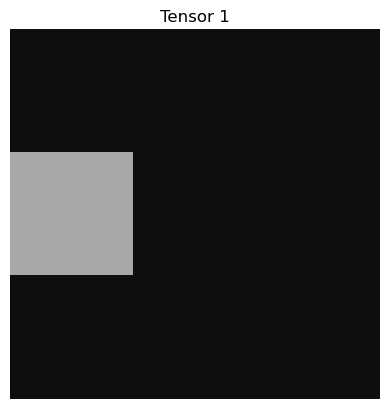

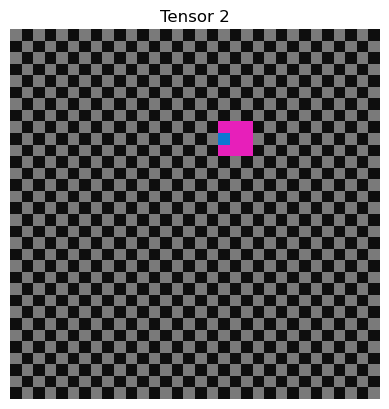

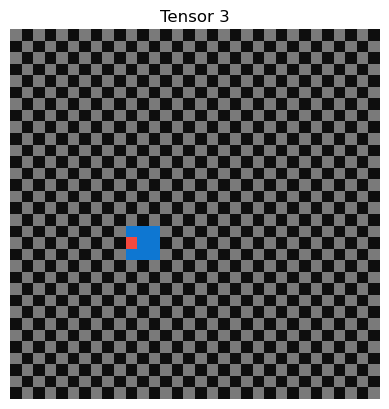

In [5]:
augmenter = DataAugmentationiBOT(2, 0)
plot_tensor_list([test_data] + augmenter(test_data))

In [6]:
iBOT_dataloader = iBOT_Dataloader(dataloader, None)

In [7]:
print(iBOT_dataloader.get_data())

[(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 0., 0.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0.